In [0]:
# Import libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import pprint as pp
import pandas as pd
from operator import itemgetter
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import pdb

## Environment

In [0]:
def place_target(env_terrains):
  a = env_terrains.shape[0] - 1

  i = random.randint(0,a)
  j = random.randint(0,a)

  return((i, j))

In [0]:
def generate_environment(a):

  env_terrains = np.zeros((a,a))

  for i in range(a):
    for j in range(a):
      terrain = random.random()
      
      if terrain < 0.2:
        env_terrains[i, j] = 5 # Flat terrain with p = 0.2
      elif terrain < 0.5:
        env_terrains[i, j] = 10 # Hilly terrain with p = 0.3
      elif terrain < 0.8:
        env_terrains[i, j] = 15 # Forested terrain with p = 0.3
      else:
        env_terrains[i, j] = 20 # Maze of caves with p = 0.2
  
  target_location = place_target(env_terrains)
  environment = (env_terrains, target_location)
  return environment

In [0]:
def display_grid(environment):
  env_grid = environment[0]
  target_location = environment[1]

  plt.figure(figsize = (8, 8))
  color_list = ['lightgreen', 'darkgreen']
  palette = sns.color_palette(color_list)
  ax = sns.heatmap(env_grid, annot = True,  linewidths = 0.01, linecolor = 'darkgray', cbar = False, xticklabels = True, yticklabels = True)
  ax.add_patch(Rectangle((target_location[1], target_location[0]), 1, 1, fill= False, capstyle = 'projecting', edgecolor='gold', linewidth = 4))
  plt.text(target_location[1] + 0.5, target_location[0] + 0.5, 'x', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 30, color = 'gold')
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show()

In [0]:
def search_cell(environment, cell):

  env_grid = environment[0]
  target_location = environment[1]

  if cell != target_location:
    return False

  else:
    if env_grid[cell] == 5:
      if random.random() < 0.9:
        return True
    elif env_grid[cell] == 10:
      if random.random() < 0.7:
        return True
    elif env_grid[cell] == 15:
      if random.random() < 0.3:
        return True
    elif env_grid[cell] == 20:
      if random.random() < 0.1:
        return True
    return False

#####Moving Target implementation in environment

In [0]:
def check_child_validity(a, cell):
    # If dimensions are in the range of the matrix dimensions (if cell is going out of bounds)
    if cell[0] == -1 or cell[1] == -1 or cell[0] == a or cell[1] == a:
        return False
    # Valid
    else:
        return True

In [0]:
def move_target(a, cell):
  
  i = cell[0]
  j = cell[1]
  neighbors = [(i - 1, j), (i , j - 1), (i , j + 1), (i + 1, j )]
  valid_neighbor = []

  for neighbor in neighbors:
    if(check_child_validity(a,neighbor)):
      valid_neighbor.append(neighbor)
  
  n = len(valid_neighbor)
  return valid_neighbor[random.randint(0,n-1)]


In [0]:
def tracker(environment):

#changing the target location and reflecting it in the environment
  a = environment[0].shape[0]
  curret_target_location = environment[1]
  new_target_location = move_target( a, curret_target_location )
  #print(new_target_location)
  environment = (environment[0], new_target_location)  
  
#report terrain type where target is not loacted. 
  terrain_of_target = terrain_type(environment, new_target_location)
  not_target = list(set([0,1,2,3]) - set([terrain_of_target]))
  t = random.randint(0,2)
  report_terrain = not_target[t]

  return environment, report_terrain

## Agent

In [0]:
def rule_1(belief_map):
  cell_index = np.unravel_index(np.argmax(belief_map, axis=None), belief_map.shape)
  return cell_index



In [0]:
def rule_2(environment, belief_map, false_negative_rate):
  
  false_negative_matrix = environment[0]/5
  for x in range(1,5):
   false_negative_matrix[false_negative_matrix == x] = (1 - false_negative_rate[x-1])

  new_probability = np.multiply(false_negative_matrix, belief_map)
  cell_index = np.unravel_index(np.random.choice(np.flatnonzero(new_probability == new_probability.max())), belief_map.shape)
  return cell_index

In [0]:
def terrain_type(environment, cell):
  return np.int(environment[0][cell]/5)-1

In [0]:
def neighbor_information(a):

  ## count of neighbours of each cell

  count_neighbor_mat = np.full((a,a),4)

  for j in range(1,a-1):
    count_neighbor_mat[0, j] = 3
    count_neighbor_mat[a-1, j] = 3
    count_neighbor_mat[j, 0] = 3
    count_neighbor_mat[j, a-1] = 3

  count_neighbor_mat[0][0] = 2
  count_neighbor_mat[0][a-1] = 2
  count_neighbor_mat[a-1][0] = 2
  count_neighbor_mat[a-1][a-1] = 2


  ## list of valid neighbours for each cell 

  valid_neighbor = [[[] for i in range(a)] for j in range(a)]

  for i in range(a):
    for j in range(a):
      neighbors = [(i - 1, j), (i , j - 1), (i , j + 1), (i + 1, j )]
      for neighbor in neighbors:
        if(check_child_validity(a,neighbor)):
          valid_neighbor[i][j].append(neighbor)

  return (count_neighbor_mat, valid_neighbor)

In [0]:
def belief_updade_given_failure(prior_belief_map, neighbor_info_map):
 ##################################################################################################################################################################
  # P( target in cell i at t+1 | observation at t)                                                                                                                 #
  #           = (summation over all j = neighbours of i) [ P(target in cell j at t | observations at t) * P (target in cell i at t+1 | target in cell j at t+1)  ] #
  #           = (summation over all j = neighbours of i) [ P(target in cell j at t | observations at t) * (1/ No. of Negibours of j) ]                             #
  ##################################################################################################################################################################

  a = prior_belief_map.shape[0]
  neigbor_count = neighbor_info_map[0]
  valid_neighbor = neighbor_info_map[1]

  updated_belief_map = np.empty((a,a))

  for i in range(a):
    for j in range(a):
      
      prob_sum = 0
      n_neighbors = neigbor_count[(i,j)]
      for n in range(np.int(n_neighbors)):
        neighbor = valid_neighbor[i][j][n]
        prob_sum = prob_sum + prior_belief_map[neighbor]

      updated_belief_map[(i,j)] = prob_sum /  n_neighbors

  return updated_belief_map


In [0]:
def terrain_type_total(environment, terrain):

  env_grid = (environment[0]/5 - 1).astype(int)
  counts = np.bincount(env_grid.flatten())

  return sum(counts) - counts[terrain]

In [0]:
def belief_update_given_tracker_info(environment, prior_belief_map, target_not_in_terrain):

  ##########################################################################################################################################################
  # P( target in cell i at t+1 | observation at t, target not in terrain T at t+1)                                                                            #
  #     =  P( target in cell i at t+1 | observation at t) * P(target not in terrain T at t+1 | observation at t, target in cell i at t+1  )                   #
  #        ---------------------------------------------------------------------------------------------------------------------------------                  #
  #                                                P(target not in terrain T at t+1 | observation at t)                                                       #
  #                                                                                                                                                           #
  #     =   Prior * [ 0  if terrain of target cell i = target_not_in_terrain,   1/3 else ]                                                                    #
  #        --------------------------------------------------------------------------------                                                                   #
  #               P(target not in terrain T at t+1 | observation at t)
  #
  #
  #
  # P(target not in terrain T at t+1 | observation at t) 
  #           = P(target in cell i at t+1  | observation at t) * P(target not in terrain T at t+1 | observation at t, target in cell i at t+1 )
  #              + P(target not in cell i at t+1  | observation at t) * P(target not in terrain T at t+1 | observation at t, target not in cell i at t+1  )
  #           =  Prior * [ 0  if terrain of target cell i = target_not_in_terrain,   1/3 else ] 
  #              + (1 - Prior) * P(target not in terrain T at t+1 | observation at t, target not in cell i at t+1  )
  #
  #############################################################################################################################################################
  a = prior_belief_map.shape[0]
  updated_belief_map = np.empty((a,a))
  n_not_terrain = terrain_type_total( environment, target_not_in_terrain)

  for i in range(a):
    for j in range(a):
      cell = (i,j)
      terrain_cell = terrain_type(environment, cell)
      
      if(terrain_cell == target_not_in_terrain):
        p = 0
        x = n_not_terrain / (a*a - 1)
      else:
        p = 1/3
        x = (n_not_terrain - 1) / (a*a - 1)

      denominator = (prior_belief_map[cell] * p) + ((1 - prior_belief_map[cell]) * x)
      updated_belief_map[cell] = (prior_belief_map[cell] * p)/denominator
  
  return updated_belief_map

####Main agent

In [0]:
def bonus_agent_rule_1(environment):

  env_grid = environment[0]
  a = env_grid.shape[0]

  initial_belief = 1/(a*a)
  belief_map = np.full((a,a), initial_belief)

  num_of_searches = 0

  ##number of neighbours map ##
  neighbor_info_map = neighbor_information(a)

  while(True):
    num_of_searches = num_of_searches + 1

    current_agent_location = rule_1(belief_map)
    is_target = search_cell(environment, current_agent_location)
    
    print("----UPDATED BELIEF MAP ----")
    sns.heatmap(belief_map, linewidths=0.2, cmap="Blues", )
    plt.text(current_agent_location[1] + 0.5, current_agent_location[0] + 0.5, 'x', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 30, color = 'red')
    plt.show()


    if(is_target):
      print("num_searches = ", num_of_searches)
      return num_of_searches
    #failure
    else:
      
      environment, target_not_in_terrain = tracker(environment)
      belief_map = belief_updade_given_failure(belief_map, neighbor_info_map)
      belief_map = belief_update_given_tracker_info(environment, belief_map, target_not_in_terrain)

  return num_searche

In [0]:
def bonus_agent_rule_2(environment):

  env_grid = environment[0]
  a = env_grid.shape[0]

  initial_belief = 1/(a*a)
  belief_map = np.full((a,a), initial_belief)
  false_negative_rate = [0.1, 0.3, 0.7, 0.9]

  num_of_searches = 0
  
  ##number of neighbours map ##
  neighbor_info_map = neighbor_information(a)

  while(True):
    num_of_searches = num_of_searches + 1

    current_agent_location = rule_2( environment ,belief_map, false_negative_rate )
    is_target = search_cell(environment, current_agent_location)
    
    print("----UPDATED BELIEF MAP ----")
    sns.heatmap(belief_map, linewidths=0.2, cmap="Blues", )
    plt.text(current_agent_location[1] + 0.5, current_agent_location[0] + 0.5, 'x', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 30, color = 'red')
    plt.show()


    if(is_target):
      print("num_searches = ", num_of_searches)
      return num_of_searches
    #failure
    else:
      
      environment, target_not_in_terrain = tracker(environment)
      belief_map = belief_updade_given_failure(belief_map, neighbor_info_map)
      belief_map = belief_update_given_tracker_info(environment, belief_map, target_not_in_terrain)

  return num_searches


----UPDATED BELIEF MAP ----


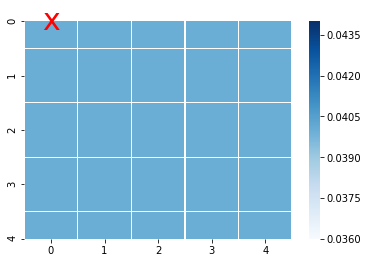

----UPDATED BELIEF MAP ----


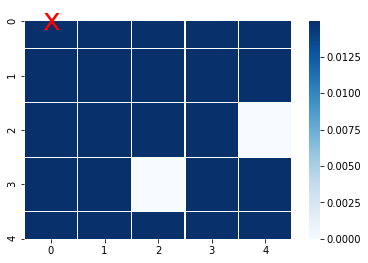

----UPDATED BELIEF MAP ----


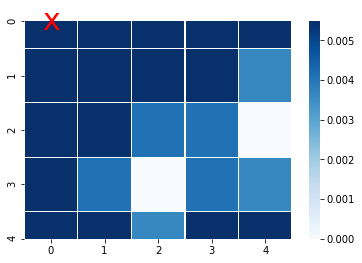

----UPDATED BELIEF MAP ----


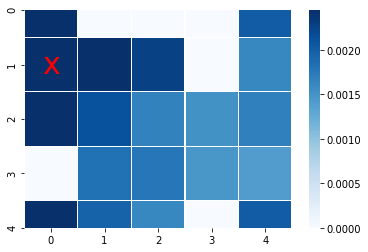

----UPDATED BELIEF MAP ----


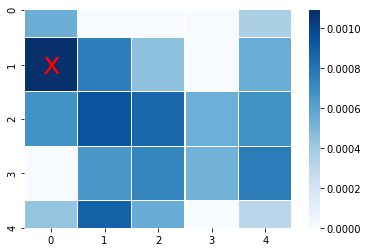

----UPDATED BELIEF MAP ----


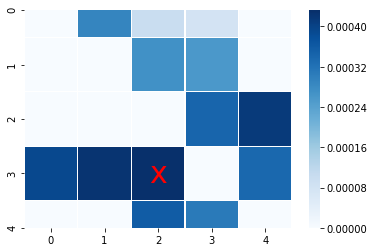

----UPDATED BELIEF MAP ----


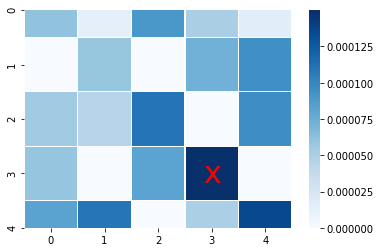

----UPDATED BELIEF MAP ----


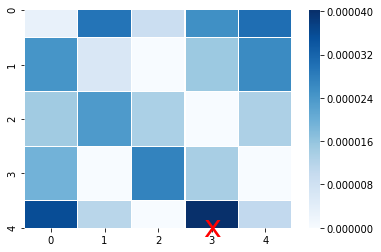

----UPDATED BELIEF MAP ----


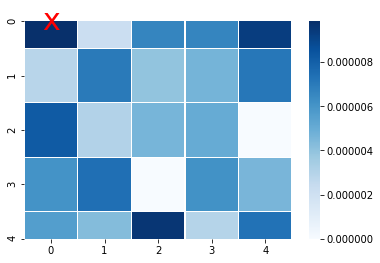

----UPDATED BELIEF MAP ----


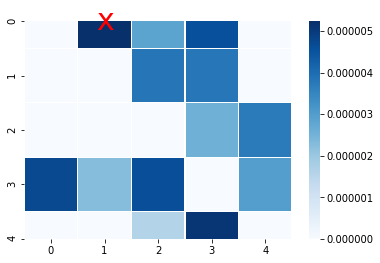

----UPDATED BELIEF MAP ----


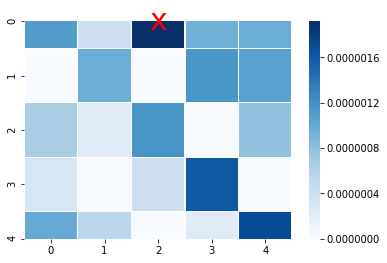

----UPDATED BELIEF MAP ----


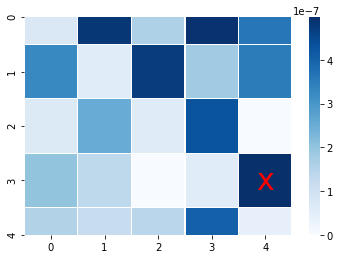

----UPDATED BELIEF MAP ----


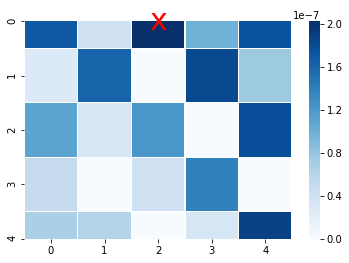

----UPDATED BELIEF MAP ----


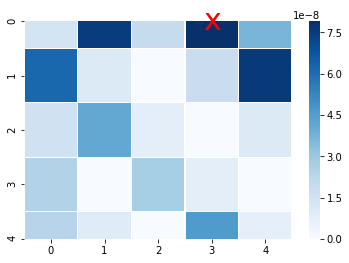

----UPDATED BELIEF MAP ----


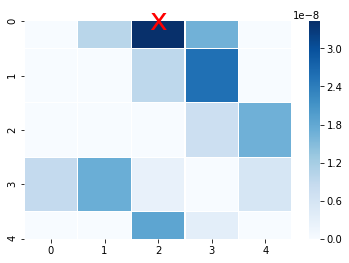

----UPDATED BELIEF MAP ----


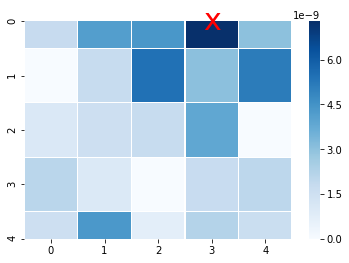

----UPDATED BELIEF MAP ----


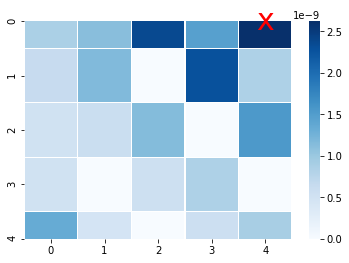

----UPDATED BELIEF MAP ----


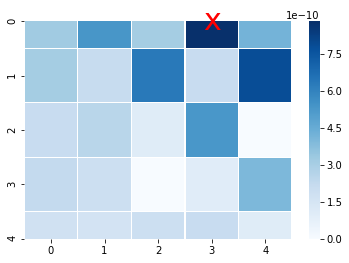

----UPDATED BELIEF MAP ----


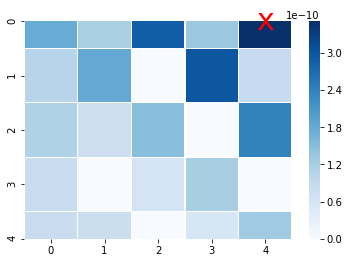

----UPDATED BELIEF MAP ----


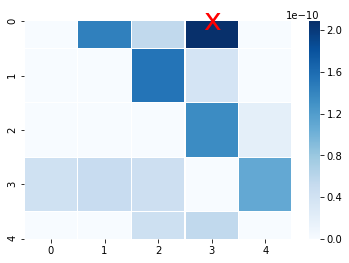

----UPDATED BELIEF MAP ----


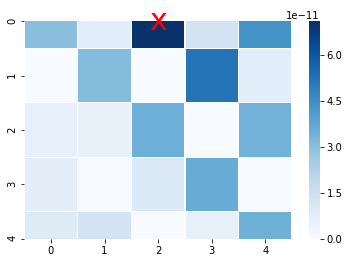

----UPDATED BELIEF MAP ----


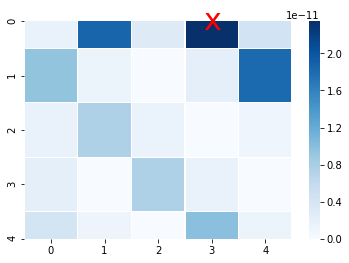

----UPDATED BELIEF MAP ----


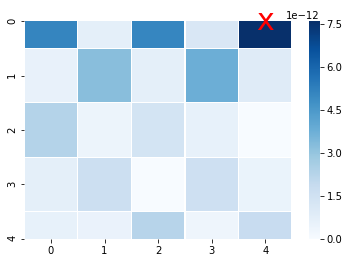

----UPDATED BELIEF MAP ----


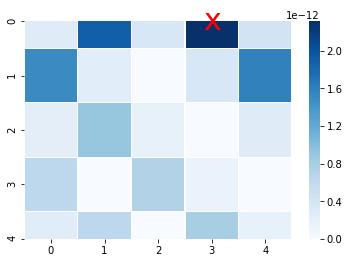

----UPDATED BELIEF MAP ----


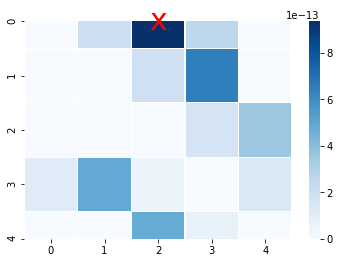

----UPDATED BELIEF MAP ----


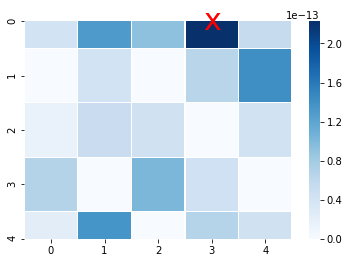

----UPDATED BELIEF MAP ----


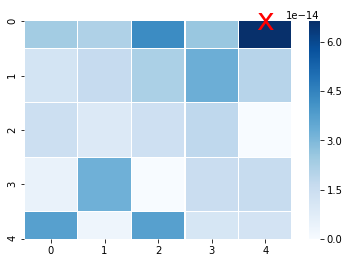

----UPDATED BELIEF MAP ----


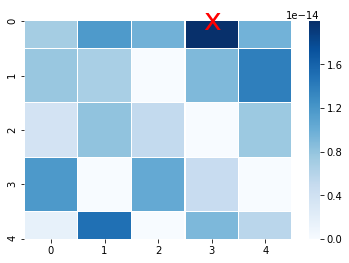

----UPDATED BELIEF MAP ----


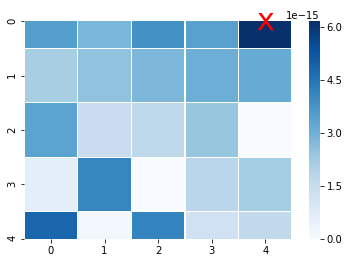

----UPDATED BELIEF MAP ----


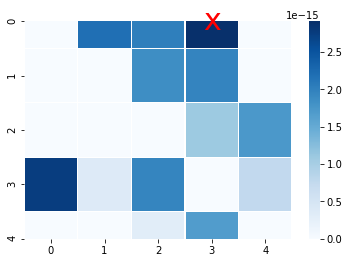

----UPDATED BELIEF MAP ----


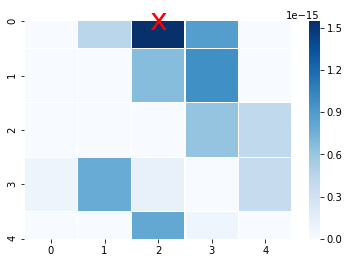

----UPDATED BELIEF MAP ----


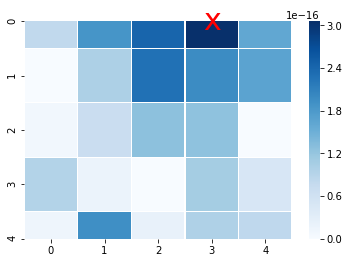

----UPDATED BELIEF MAP ----


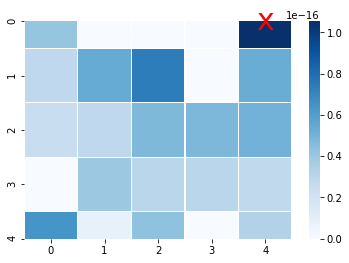

----UPDATED BELIEF MAP ----


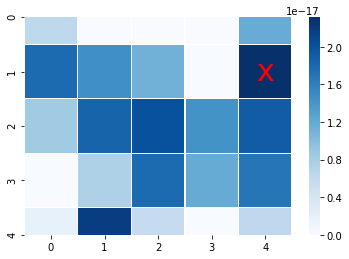

----UPDATED BELIEF MAP ----


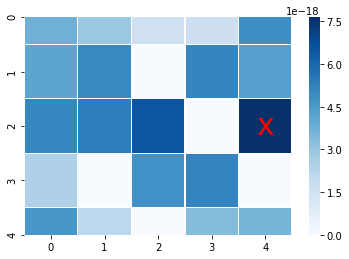

----UPDATED BELIEF MAP ----


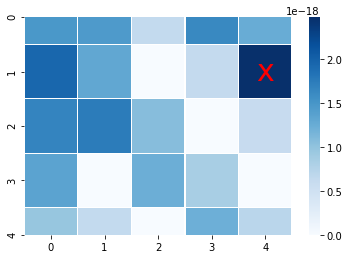

----UPDATED BELIEF MAP ----


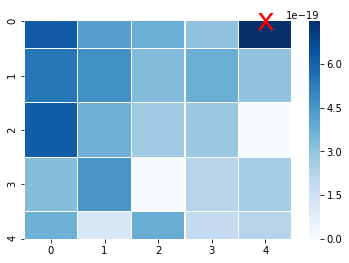

----UPDATED BELIEF MAP ----


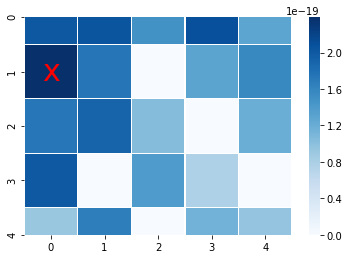

----UPDATED BELIEF MAP ----


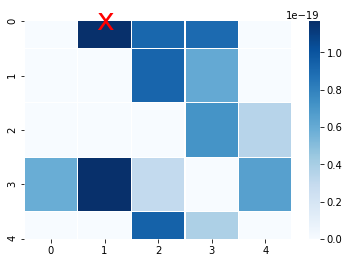

----UPDATED BELIEF MAP ----


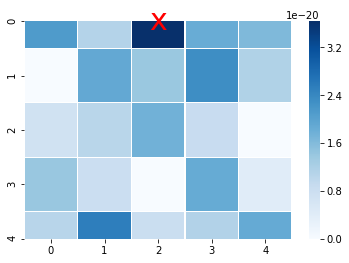

----UPDATED BELIEF MAP ----


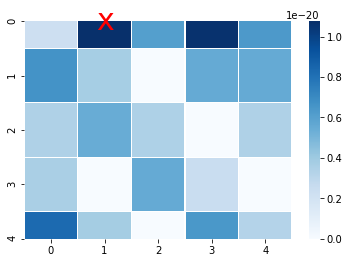

----UPDATED BELIEF MAP ----


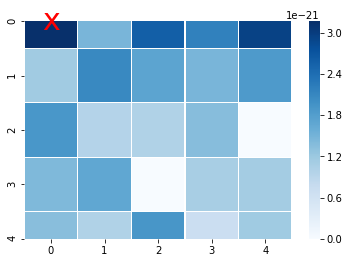

----UPDATED BELIEF MAP ----


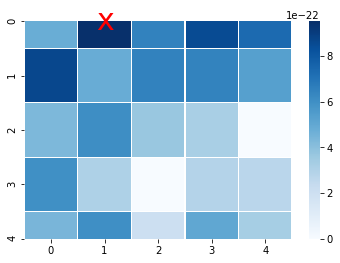

----UPDATED BELIEF MAP ----


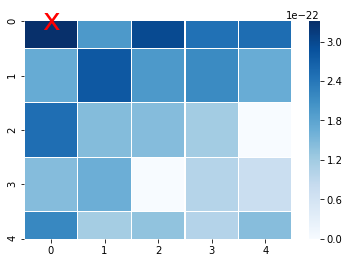

----UPDATED BELIEF MAP ----


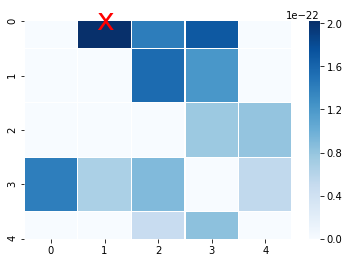

----UPDATED BELIEF MAP ----


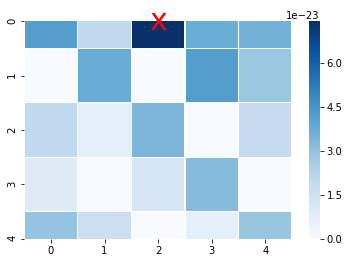

----UPDATED BELIEF MAP ----


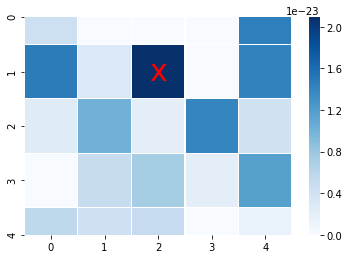

----UPDATED BELIEF MAP ----


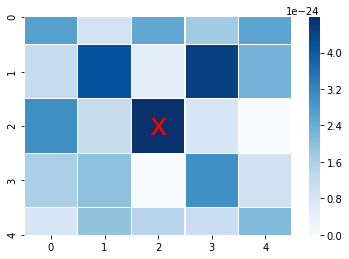

num_searches =  48


48

In [94]:
## Call to the agent #

a = 5
environment = generate_environment(a)
bonus_agent_rule_1(environment)

## Analysing the performance

In [0]:
def analysis(a, n):

	sum_searches_rule_1 = 0
	sum_searches_rule_2 = 0
	for i in range(n):

		print("Trial: ", i)
		environment = generate_environment(a)
		sum_searches_rule_1 = sum_searches_rule_1 + bonus_agent_rule_1(environment)
		sum_searches_rule_2 = sum_searches_rule_2 + bonus_agent_rule_2(environment)

	avg_searches_rule_1 = sum_searches_rule_1/n
	avg_searches_rule_2 = sum_searches_rule_2/n
	print(avg_searches_rule_1)
	print(avg_searches_rule_2)

	plt.bar(["Rule 1", "Rule 2"], [avg_searches_rule_1, avg_searches_rule_2])
	plt.ylabel("Average no. of searches")
	fig1 = plt.gcf()
	plt.show()
	fig1.savefig('bonus_rule_1_2.png')

In [0]:
#analysis(50, 50)